In [141]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F

sns.set_theme(
    context="notebook",
    style="whitegrid",
    palette="deep",
    font="serif",
    font_scale=1,
    color_codes=True,
    rc={"figure.dpi": 150},
)

curdir = Path.cwd()
sys.path.append(str(curdir.parent))
from utils.metrics import dice_batch

results_path = curdir.parent / "results"
data_path = curdir.parent / "data"

dataset = "segthor_train"  # 3D

categories = ["Background", "Esophagus", "Heart", "Trachea", "Aorta"]
K = len(categories)

experiments_path = results_path / dataset
experiments = sorted(list(experiments_path.iterdir()))
print("Found experiments:")
for i, exp in enumerate(experiments):
    print(f"{i}: {exp.stem}")

experiment = experiments[1]

Found experiments:
0: segvol_0_zeroshot
1: segvol_1_dicece_lr0
2: segvol_3_dicefocal_lr0
3: segvol_4_dicefocal_lr0


In [46]:
def process_experiment(experiment):
    # This assumes you have a folder with results as PatientID.nii.gz   
    patients = list(filter(lambda x: ".nii.gz" in x.name, experiment.iterdir()))

    store = np.zeros((len(patients), K))
    gt_path = data_path / dataset / "train"
    for i, patient in enumerate(patients):
        patient_id = patient.stem.split(".")[0] # PatientID.nii.gz -> PatientID
        print(patient_id)
        pred = np.asarray(nib.load(patient).dataobj)
        gt = np.asarray(nib.load(gt_path / patient_id / "GT.nii.gz").dataobj)
        pred, gt = torch.from_numpy(pred), torch.from_numpy(gt)
        pred, gt = (
            F.one_hot(pred.long(), K).permute(3, 0, 1, 2),
            F.one_hot(gt.long(), K).permute(3, 0, 1, 2),
        )
        dice = dice_batch(gt.unsqueeze(0), pred.unsqueeze(0))
        store[i] = dice.cpu().numpy()
        del pred, gt
        print(dice)

    np.save(experiment / "dice_pred.npy", store)


process_experiment(experiments[0])
process_experiment(experiments[1])

Patient_10
tensor([0.9990, 0.9661, 0.9195, 0.9805, 0.9722])
Patient_02
tensor([0.9997, 0.9583, 0.9523, 0.9810, 0.9773])
Patient_34
tensor([0.9994, 0.9750, 0.9406, 0.9659, 0.9769])
Patient_38
tensor([0.9995, 0.9588, 0.9500, 0.9666, 0.9661])
Patient_26
tensor([0.9995, 0.9632, 0.9403, 0.9670, 0.9747])
Patient_12
tensor([0.9994, 0.9459, 0.9564, 0.9691, 0.9752])
Patient_24
tensor([0.9994, 0.9501, 0.9348, 0.9512, 0.9778])
Patient_36
tensor([0.9995, 0.9612, 0.9513, 0.9714, 0.9762])
Patient_28
tensor([0.9992, 0.9589, 0.9535, 0.9694, 0.9748])
Patient_32
tensor([0.9994, 0.9715, 0.9596, 0.9786, 0.9792])
Patient_20
tensor([0.9997, 0.9373, 0.9545, 0.9550, 0.9572])
Patient_16
tensor([0.9994, 0.9581, 0.9480, 0.9587, 0.9771])
Patient_08
tensor([0.9996, 0.9472, 0.9425, 0.9794, 0.9730])
Patient_04
tensor([0.9996, 0.9543, 0.9617, 0.9803, 0.9706])
Patient_22
tensor([0.9995, 0.9499, 0.9426, 0.9721, 0.9793])
Patient_30
tensor([0.9994, 0.9627, 0.9496, 0.9641, 0.9732])
Patient_18
tensor([0.9994, 0.9204, 0.971

## SegVol Results

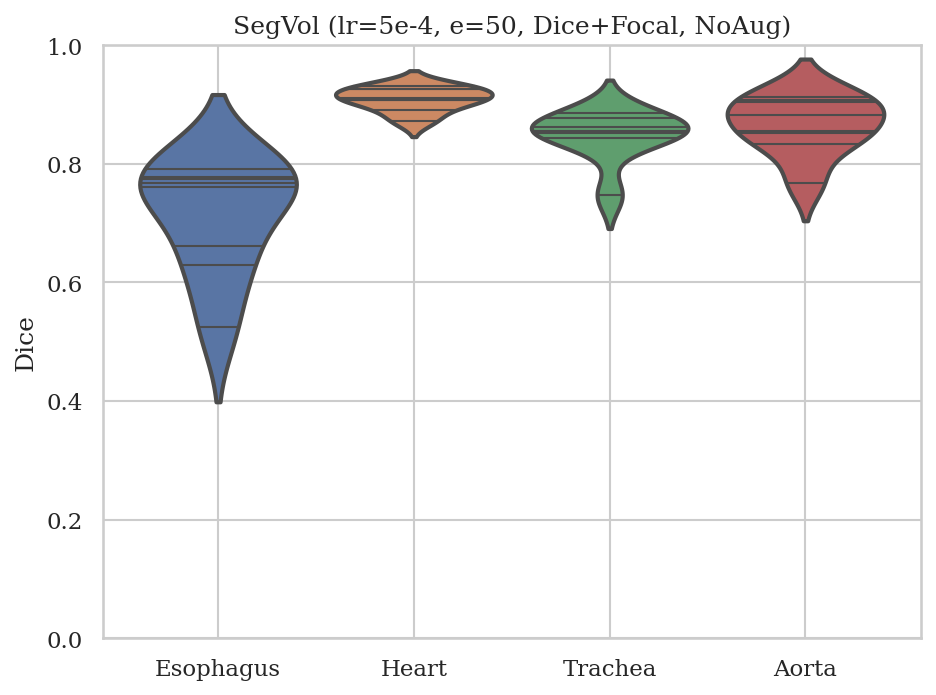

In [32]:
experiment = experiments[0]
store = np.load(experiment / "dice_pred.npy")
store = store[:, 1:]  # Exclude background
sns.violinplot(
    data=store,
    density_norm="width",
    native_scale=True,
    linewidth=2,
    common_norm=False,
    inner="stick",
)
plt.ylim(0, 1)
plt.xticks(ticks=np.arange(K - 1), labels=categories[1:])
plt.ylabel("Dice")
plt.title(f"SegVol (lr=5e-4, e=50, Dice+Focal, NoAug)")
plt.tight_layout()
save_dir = curdir / experiment.stem / "dice_pred.png"
save_dir.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_dir, bbox_inches="tight")

## Display Violin plots side by side.

,Experiment,Category,Dice
0,Aug,Esophagus,0.773900
1,Aug,Esophagus,0.628600
2,Aug,Esophagus,0.790200
3,Aug,Esophagus,0.767100
4,Aug,Esophagus,0.661500
...,...,...,...
59,NoAug,Aorta,0.781423
60,NoAug,Aorta,0.824589
61,NoAug,Aorta,0.781207
62,NoAug,Aorta,0.847573


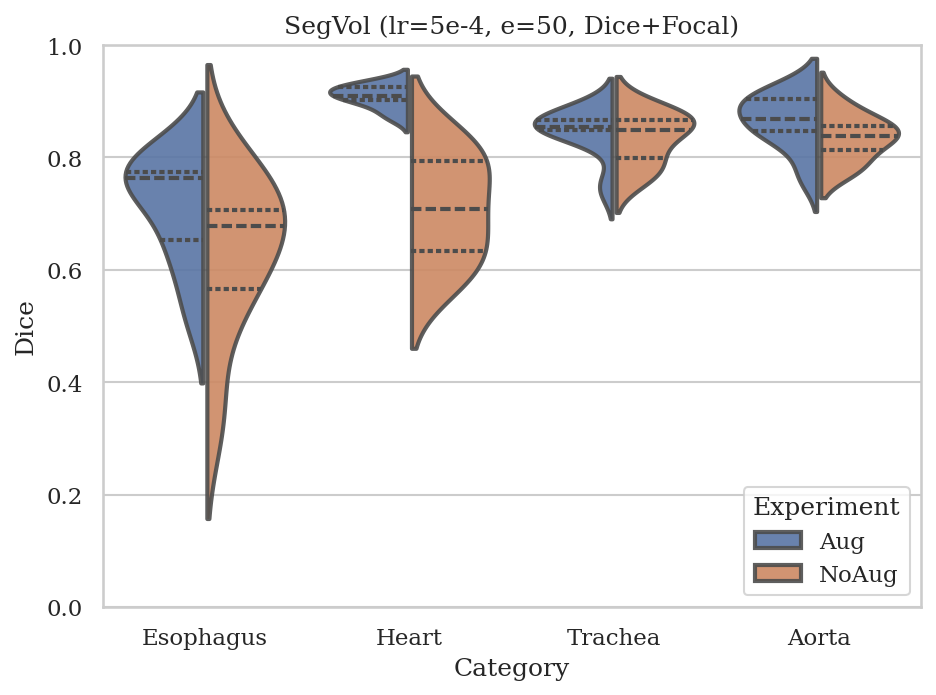

In [36]:
store_1 = np.load(experiments[0] / "dice_pred.npy")
store_1 = store_1[:, 1:]  # Exclude background

store_2 = np.load(experiments[1] / "dice_pred.npy")
store_2 = store_2[:, 1:]  # Exclude background

df = pd.concat(
    [
        pd.DataFrame(store_1, columns=categories[1:]).assign(Experiment="Aug"),
        pd.DataFrame(store_2, columns=categories[1:]).assign(Experiment="NoAug"),
    ]
)

# Convert dataframe from wide-form to long-form
df_long = pd.melt(df, id_vars=["Experiment"], var_name="Category", value_name="Dice")
display(df_long)
# Create a violin plot
sns.violinplot(
    data=df_long,
    x="Category",
    y="Dice",
    hue="Experiment",
    density_norm="count",
    native_scale=True,
    linewidth=2,
    gap=0.05,
    common_norm=False,
    split=True,
    inner="quart",
    alpha=0.9,
)

plt.ylim(0, 1)
plt.ylabel("Dice")
plt.title(f"SegVol (lr=5e-4, e=50, Dice+Focal)")
plt.tight_layout()
save_dir = curdir / "dice_pred_aug_vs_noaug.png"
plt.savefig(save_dir, bbox_inches="tight")

In [140]:
print(sorted(experiments))

[PosixPath('/Users/Matey/project/ai4mi_project/results/segthor_train/segvol_0_zeroshot'), PosixPath('/Users/Matey/project/ai4mi_project/results/segthor_train/segvol_1_dicece_lr0.0005_e50_noaug'), PosixPath('/Users/Matey/project/ai4mi_project/results/segthor_train/segvol_3_dicefocal_lr0.0005_e50_noaug'), PosixPath('/Users/Matey/project/ai4mi_project/results/segthor_train/segvol_4_dicefocal_lr0.0005_e50_aug')]


In [142]:
# We need a table of the shape
# Method | Class 1 | Class 2 | Class 3 | Class 4 | Mean
#        | DICE/HD | DICE/HD | DICE/HD | DICE/HD | DICE/HD
# ENet w/ D+CE   | --
# Enet w/ D+F    | Mean+-std
# ENet w/ D
# --------------
# nnUNet w/ D+CE
# nnUNet w/ D+F
# nnUNet w/ D+F+Aug
# --------------
# SegVol Zero-shot
# SegVol w/ D+CE
# SegVol w/ D+CE=Aug
# SegVol w/ D+F
# SegVol w/ D+F+Aug

# Define the methods and their corresponding experiment files
# TODO: Fix when I have results for dicece+aug, and HD scores
methods = [
    ("SegVol Zero-shot", experiments[0]),
    ("SegVol w/ D+CE", experiments[1]),
    ("SegVol w/ D+CE+Aug", Path()),
    ("SegVol w/ D+F", experiments[2]),
    ("SegVol w/ D+F+Aug", experiments[3]),
]

rows = []
# Process each method and its corresponding experiment file
for method, exp_path in methods:
    # Load DICE and HD data
    npy_path = exp_path / "dice_pred.npy"
    if not npy_path.exists():
        continue
        
    dice_data = np.load(npy_path)
    # hd_data = np.load(exp_path / "hd_pred.npy")
    hd_data = np.ones_like(dice_data) * np.nan

    # Create DataFrames for DICE and HD
    dice_df = pd.DataFrame(dice_data, columns=categories)
    hd_df = pd.DataFrame(hd_data, columns=categories)

    # Calculate mean and std deviation for DICE
    dice_mean = dice_df.mean(axis=0) * 100
    dice_std = dice_df.std(axis=0) * 100

    # Calculate mean and std deviation for HD
    hd_mean = hd_df.mean(axis=0)
    hd_std = hd_df.std(axis=0)

    # Combine mean and std into a single string for each category
    dice_combined = dice_mean.map("{:.2f}".format) + "±" + dice_std.map("{:.1f}".format)
    hd_combined = hd_mean.map("{:.2f}".format) + "±" + hd_std.map("{:.1f}".format)

    # Calculate overall mean and std for DICE and HD
    overall_dice_mean = dice_mean.mean()
    overall_dice_std = dice_std.mean()
    overall_dice_combined = f"{overall_dice_mean:.2f}±{overall_dice_std:.1f}"

    overall_hd_mean = hd_mean.mean()
    overall_hd_std = hd_std.mean()
    overall_hd_combined = f"{overall_hd_mean:.2f}±{overall_hd_std:.1f}"

    # Append the results to the DataFrame
    row = {("Method", ""): method}
    for category in categories[1:]:
        row.update(
            {
                (category, "DICE"): dice_combined[category],
                (category, "HD"): hd_combined[category],
            }
        )
    row.update(
        {("Mean", "DICE"): overall_dice_combined, ("Mean", "HD"): overall_hd_combined}
    )
    rows.append(row)

# Create the final DataFrame
results = pd.DataFrame(rows)

# Set the multi-level columns
results.columns = pd.MultiIndex.from_tuples(results.columns)

# Display the results DataFrame
display(results)


# Convert the DataFrame to LaTeX format
# Highlight the maximum value in each column, excluding the first column
latex_output = (
    results.style.hide(axis=0)
    .highlight_max(subset=results.columns[1:], props="font-weight:bold")
    .to_latex(column_format="c" * len(results.columns), convert_css=True, hrules=True)
    .replace("nan±nan", "--")
    .replace(r"{r}", r"{c}")
    .replace(r"±", r"\small ±")
)
print(latex_output)

Method   Esophagus               Heart             Trachea  \
                            DICE       HD       DICE       HD       DICE   
0      SegVol w/ D+F  62.93±14.0  nan±nan  70.91±9.4  nan±nan  83.36±4.6   
1  SegVol w/ D+F+Aug   71.06±9.6  nan±nan  90.89±2.0  nan±nan  84.67±4.3   

                Aorta                Mean           
        HD       DICE       HD       DICE       HD  
0  nan±nan  83.50±4.0  nan±nan  80.08±6.4  nan±nan  
1  nan±nan  86.41±4.9  nan±nan  86.59±4.1  nan±nan

\begin{tabular}{ccccccccccc}
\toprule
Method & \multicolumn{2}{c}{Esophagus} & \multicolumn{2}{c}{Heart} & \multicolumn{2}{c}{Trachea} & \multicolumn{2}{c}{Aorta} & \multicolumn{2}{c}{Mean} \\
 & DICE & HD & DICE & HD & DICE & HD & DICE & HD & DICE & HD \\
\midrule
SegVol w/ D+F & 62.93\small ±14.0 & \bfseries -- & 70.91\small ±9.4 & \bfseries -- & 83.36\small ±4.6 & \bfseries -- & 83.50\small ±4.0 & \bfseries -- & 80.08\small ±6.4 & \bfseries -- \\
SegVol w/ D+F+Aug & \bfseries 71.06\small ±9.6 & \bfseries -- & \bfseries 90.89\small ±2.0 & \bfseries -- & \bfseries 84.67\small ±4.3 & \bfseries -- & \bfseries 86.41\small ±4.9 & \bfseries -- & \bfseries 86.59\small ±4.1 & \bfseries -- \\
\bottomrule
\end{tabular}

